In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from lib.metrics import c_index

In [4]:
data_path = "dataset/synthetic_dataset.xlsx"

In [5]:
df = pd.read_excel(data_path)
# df = df.sort_values(by='time_to_event', ascending=True)
display(df.head())

,age,bmi,diabetes,hypertension,donor_age,cold_ischemia_time,time_to_event,event_occurred
0,54.967142,21.607526,0,0,0,11.116362,15.667234,1
1,48.617357,23.472503,1,1,0,9.371048,3.747069,1
2,56.476885,22.013095,1,0,1,11.119127,0.125769,1
3,65.230299,25.552090,1,0,1,11.976611,0.531278,1
4,47.658466,30.985893,0,1,1,8.251352,0.199634,1


In [6]:
df["time_to_event"]=df["time_to_event"].apply(lambda x: x)
df

,age,bmi,diabetes,hypertension,donor_age,cold_ischemia_time,time_to_event,event_occurred
0,54.967142,21.607526,0,0,0,11.116362,15.667234,1
1,48.617357,23.472503,1,1,0,9.371048,3.747069,1
2,56.476885,22.013095,1,0,1,11.119127,0.125769,1
3,65.230299,25.552090,1,0,1,11.976611,0.531278,1
4,47.658466,30.985893,0,1,1,8.251352,0.199634,1
...,...,...,...,...,...,...,...,...
9995,63.011021,26.939137,1,0,1,11.103522,0.258145,1
9996,30.016550,31.886833,0,0,0,8.597866,3.551936,1
9997,42.946833,26.891770,0,0,0,7.489440,60.000000,0
9998,54.957656,33.567649,0,1,0,5.366228,1.419426,1


In [7]:
# Assuming 'df' is your Pandas DataFrame
# 'features' are your independent variables, 'target' is your dependent variable
X = df[[col for col in list(df.columns) if col not in ["time_to_event", "event_occurred"]]]
y = df[['time_to_event', "event_occurred"]] # Select your target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

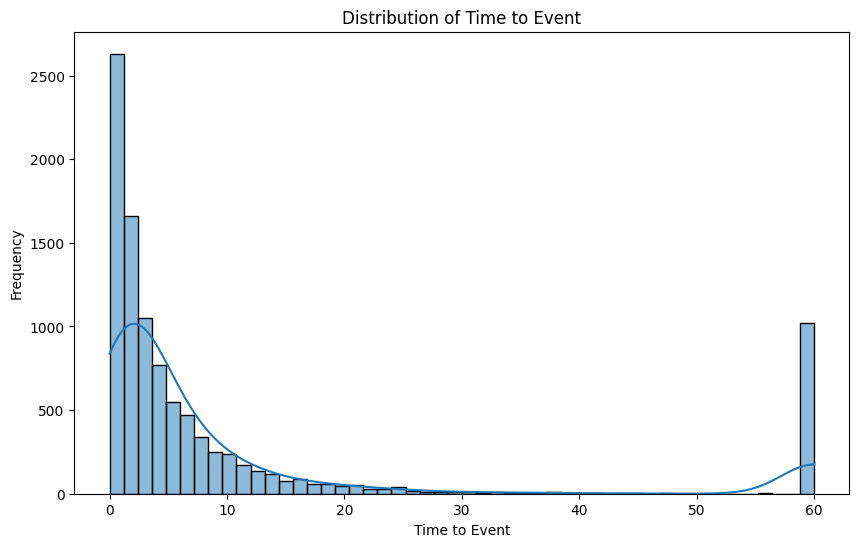

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['time_to_event'], bins=50, kde=True)
plt.title('Distribution of Time to Event')
plt.xlabel('Time to Event')
plt.ylabel('Frequency')
plt.show()

# Simple Cox Model with learnable Harzard Rate

In proportional harzard rate, we have:
$$h(t, \mathbf{x})=g_xh_0(t)$$

In which $g_x= g(\boldsymbol{\theta}, \boldsymbol{x}), h_0(t) = \lambda_0$, in which $\lambda_0$ is initial harzard rate. In this case:

$$\tilde{F_i}(t, \mathbf{x}) = \tilde{F_0}(t)^{g_{\mathbf{x}_i}}$$

with $\tilde{F_0}(t)= \lambda_0 e^{-\lambda x}$

The MLE of the distribution function is:

$$L(\lambda, \beta) = \prod_{obs}\tilde{f_{}}(t, x)\prod_{cens}\tilde{F_{}}(t, x) = \prod_{i=1}^n h(t_i, \mathbf{x_i})^{c_i}\tilde{F_i}(t, \mathbf{x})$$


$c_i = 1$ if the event $t_i$ is observed. Otherwise, $c_i = 0$

## `SurvivalDataSet` class

In [ ]:
class SurvivalDataset(Dataset):
  def __init__(self, X, y):
    self.features = X
    self.labels = y

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    data = self.features[idx]
    label = self.labels[idx]
    return data, label

## Define Neural Network

### Simple Neural Network

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(1),
            nn.Softplus(),
        )

    def forward(self, x):
        return self.net(x)


class NLL(nn.Module):
    def __init__(self, initial_lambda=0.1):
        super().__init__()
        self.log_lambda = nn.Parameter(torch.tensor(np.log(initial_lambda)))

    def forward(self, preds, failure_times, is_observed):
        # Number of observed events
        d = torch.sum(is_observed)
        log_of_sum = torch.log(torch.sum(preds * failure_times) + 1e-8)
        sum_of_log = torch.sum(is_observed * torch.log(preds))

        nll = d * log_of_sum - sum_of_log
        return nll

### Cox PH Model

In [ ]:
class CoxPH(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(1),
        )

    def forward(self, x):
        return self.net(x)

class CoxPHLoss(nn.Module):
    """
    Cox Proportional Hazards partial likelihood loss.
    Efficient implementation using the Breslow approximation for tied events.
    """
    def __init__(self):
        super().__init__()

    def forward(self, log_h, durations, events):
        """
        Args:
            log_h: log hazard ratio predictions from model, shape (batch_size,)
            durations: observed time (either event or censoring time), shape (batch_size,)
            events: event indicator (1 if event, 0 if censored), shape (batch_size,)

        Returns:
            loss: negative log partial likelihood
        """
        # Sort by time
        sorted_durations, sorted_indices = torch.sort(durations)
        sorted_log_h = log_h[sorted_indices]
        sorted_events = events[sorted_indices]

        # Calculate negative partial log-likelihood
        log_likelihood = 0.0

        for i in range(len(sorted_durations)):
            if sorted_events[i] == 1:  # If an event occurred
                # Risk set: all individuals still at risk at time t_i
                # (includes individual i and all individuals with longer times)
                risk_set_log_h = sorted_log_h[i:]

                # Log partial likelihood contribution
                # log h_i - log(sum of exp(log h_j) for j in risk set)
                log_likelihood += sorted_log_h[i] - torch.logsumexp(risk_set_log_h, dim=0)

        return -log_likelihood  # Return negative for minimization

In [ ]:
# seed random
torch.manual_seed(29)
# model = CoxPH()
# loss_fn = CoxPHLoss()

model = NeuralNetwork()
loss_fn = NLL()

In [ ]:
train_dataset = SurvivalDataset(X_train.to_numpy(), y_train.to_numpy())
test_dataset = SurvivalDataset(X_test.to_numpy(), y_test.to_numpy())

In [ ]:
for feature, label in test_dataset:
  if label[1] == 0:
    feature = torch.from_numpy(feature).to(torch.float32)
    print("Lambda prediction for censored case:", model(feature))
    break

for feature, label in test_dataset:
  if label[1] == 1:
    feature = torch.from_numpy(feature).to(torch.float32)
    print("Lambda prediction for observed case:", model(feature))
    break

Lambda prediction for censored case: tensor([1.6538], grad_fn=<SoftplusBackward0>)
Lambda prediction for observed case: tensor([2.1993], grad_fn=<SoftplusBackward0>)


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
      X = X.to(torch.float32)
      y = y.to(torch.float32)

      preds = model(X)
      loss = loss_fn(preds, y[:, 0], y[:, 1])

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 10 == 0:
        # print(model.net[0].weight.grad)
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
learning_rate = 0.0001
batch_size = 64
epochs = 50

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
c_indices = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)

    scheduler.step()

    # After each epoch, evaluate C-index
    model.eval()
    with torch.no_grad():
        all_risks = []
        all_times = []
        all_events = []

        for X, y in test_loader:
            X = X.to(torch.float32)
            risks = model(X)

            all_risks.append(risks)
            all_times.append(y[:, 0])  # Event times
            all_events.append(y[:, 1])  # Event indicators

        all_risks = torch.cat(all_risks)
        all_times = torch.cat(all_times)
        all_events = torch.cat(all_events)

        c_idx = c_index(all_risks, all_times, all_events)
        c_indices.append(c_idx)
        print(f"C-index: {c_idx:.4f}")
print("Done!")

Epoch 1
-------------------------------
loss: -824.433167  [   64/ 7000]
loss: -1264.536377  [  704/ 7000]
loss: -1751.575439  [ 1344/ 7000]
loss: -2284.082031  [ 1984/ 7000]
loss: -2716.694336  [ 2624/ 7000]
loss: -2887.375488  [ 3264/ 7000]
loss: -3135.309570  [ 3904/ 7000]
loss: -3496.214355  [ 4544/ 7000]
loss: -3819.538574  [ 5184/ 7000]
loss: -4161.659180  [ 5824/ 7000]
loss: -4299.036621  [ 6464/ 7000]
Concordant: 2716452
Discordant: 1736596
Tied Risk: 1
Tied Time: 0
C-index: 0.6100
Epoch 2
-------------------------------
loss: -4771.851562  [   64/ 7000]
loss: -4779.039062  [  704/ 7000]
loss: -4987.163086  [ 1344/ 7000]
loss: -5130.849121  [ 1984/ 7000]
loss: -5568.808594  [ 2624/ 7000]
loss: -5415.489746  [ 3264/ 7000]
loss: -5511.309082  [ 3904/ 7000]
loss: -6042.691406  [ 4544/ 7000]
loss: -6184.750000  [ 5184/ 7000]
loss: -6501.045410  [ 5824/ 7000]
loss: -5956.004883  [ 6464/ 7000]
Concordant: 2766552
Discordant: 1686497
Tied Risk: 0
Tied Time: 0
C-index: 0.6213
Epoch 3
-

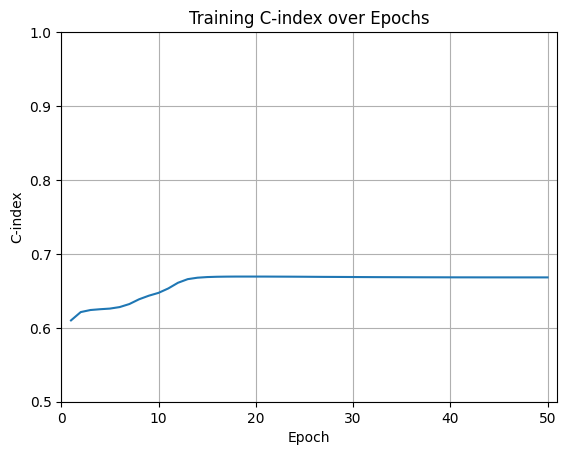

In [ ]:
plt.figure()
plt.plot(range(1, epochs + 1), c_indices)
plt.title('Training C-index over Epochs')
plt.xlabel('Epoch')
plt.ylabel('C-index')
plt.xticks(np.arange(0, epochs + 10, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 51)
plt.ylim(0.5, 1)
plt.grid(True)
plt.show()

In [ ]:
# !pip install scikit-survival

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# %matplotlib inline

# from sklearn import set_config
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OrdinalEncoder

# from sksurv.datasets import load_gbsg2
# from sksurv.ensemble import RandomSurvivalForest
# from sksurv.preprocessing import OneHotEncoder

# set_config(display="text")  # displays text representation of estimators

In [ ]:
# # Swap columns of y_train and y_test
# y_train = y_train[['event_occurred', 'time_to_event']]
# y_test = y_test[['event_occurred', 'time_to_event']]

In [ ]:
# y_train_rsf = y_train[['event_occurred', 'time_to_event']]

In [ ]:
# y_train

In [ ]:
# y_train_rsf = np.array(list(zip(y_train['event_occurred'].astype(bool), y_train['time_to_event'])),
#                        dtype=[('event_occurred', bool), ('time_to_event', float)])
# print(y_train_rsf)

In [ ]:
# c_index = rsf.score(X_test, y_test_rsf)
# f"{c_index:.5f}"